In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import cv2
from tqdm.notebook import tqdm

from fastai.vision.all import *
from fastai.vision import models
import torch

In [15]:
sz = 128
zoom = 60

In [16]:
path = '../input/preview_set/'
df = pd.read_csv(os.path.join(path, f'train_{zoom}.csv'))
df.head()

,fn,is_val,target_fn
0,input_60_128/1.npy,True,target_60_128/1.png
1,input_60_128/2.npy,False,target_60_128/2.png
2,input_60_128/3.npy,False,target_60_128/3.png
3,input_60_128/4.npy,False,target_60_128/4.png
4,input_60_128/5.npy,False,target_60_128/5.png


In [64]:
class BrightfieldImage(TensorImage):
    
    @classmethod
    def create(cls, fn):
        im = TensorImage(np.load(fn))
        
        mean = tensor([519.06234031, 518.50844388, 518.53247025, 518.56737158, 518.57572727, 518.62912976, 518.68634407])
        std = tensor([275.56237411, 270.05320819, 260.81917046, 249.73119559, 233.28654046, 216.3005945, 193.18197006])
        
        im = im * (256**2 - 1)
        im = (im - mean) / std
        
        return cls(im.permute(2,0,1))
    
    def show(self, ctx=None, **kwargs): 
        img = self
        if not isinstance(img, Tensor):
            t = tensor(img)
            t = t.permute(2,0,1)
        else: 
            t = img
            
        t = t.permute(1,2,0)
        
        # denormalize
        mean = tensor([519.06234031, 518.50844388, 518.53247025, 518.56737158, 518.57572727, 518.62912976, 518.68634407])
        std = tensor([275.56237411, 270.05320819, 260.81917046, 249.73119559, 233.28654046, 216.3005945, 193.18197006])
        t = (t * std) + mean
        t = t / (256**2 - 1)
        
        # convert to 3D PCA - these are pca components fractions for each brightfield channel
        red_comp = tensor([0.39423992, 0.43700847, 0.44657826, 0.42102395, 0.36548955, 0.30311383, 0.22681394])
        green_comp = tensor([-0.52929354, -0.39814758, -0.12413004, 0.16665499, 0.37310351, 0.44822793, 0.42193625])
        blue_comp = tensor([-0.49489557, -0.05811184, 0.43123788, 0.47214236, 0.08612177, -0.29430201, -0.49878477])
        
        h,w,c = t.shape
        t = t.view(-1,c).float()
        
        t = torch.stack([
            torch.matmul(t, red_comp),
            torch.matmul(t, green_comp),
            torch.matmul(t, blue_comp),
        ], dim=1)
        
        # normalize according to pca stats to better cover the full 0-1 range for visualization
        t = t / tensor([0.25,0.11,0.02])
        brighten_factor = 5
        t = t*brighten_factor
        t = t.view(h,w,-1)
        t = t.clamp(0.,1.).permute(2,0,1)
        
        return show_image(t, title='Brightfield', ctx=ctx, **kwargs)
    
class FluorescenceImage(TensorImage):
    @classmethod
    def create(cls, fn):
        im = TensorImage(cv2.imread(fn, -1).astype(np.float32))
        # normalize
        mean = tensor([327.79297103, 1548.88373241, 341.84451986])
        std = tensor([418.48723383, 1097.49263918, 131.44001168])
        im = (im - mean) / std
        
        return cls(im.permute(2,0,1))
    
    def show(self, ctx=None, **kwargs):
        img = self
        if not isinstance(img, Tensor):
            t = tensor(img)
            t = t.permute(2,0,1)
        else: 
            t = img
            
        t = t.permute(1,2,0)
        
        # better cover the full 0-1 range for visualization
        t = (t + 2.) / 4.0
        t = t.clamp(0.,1.).permute(2,0,1)
        
        return show_image(t, title='Fluorescence', ctx=ctx, **kwargs)

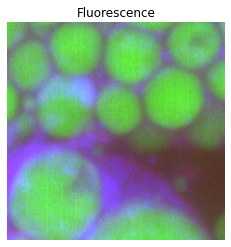

In [65]:
targ = FluorescenceImage.create(os.path.join(path, df.iloc[100].target_fn))
targ.show();

In [66]:
#targ_aug = Resize(32)(targ)
#targ_aug.show()

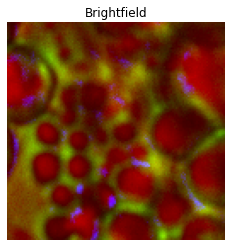

In [67]:
s = BrightfieldImage.create(os.path.join(path, df.iloc[25].fn))
s.show();

## Transform

In [100]:
from enum import Enum

class ImageTypes(Enum):
    brightfield = 1
    fluorescence = 2

class BrightfieldFluorescenceTransform(Transform):
    def __init__(self,
                 brightfield_paths:list, 
                 fluorescence_paths:list,
                 augment_func:callable=None,
                 augment_samples:list=None,
                ):
        """
        Apply transforms for brightfield and fluorescence images.
        
        Arguments:
            brightfield_paths   (list:str): brightfield numpy array file paths
            fluorescence_paths  (list:str): fluorescence image paths paths
            augment_func        (callable): augmentation function that takes in dictionary with
                                            ImageTypes.brightfield and ImageTypes.fluorescence keys
            augment_samples    (list:bool): boolean list that tells which samples are augmented
        """
        self.brightfield_paths = brightfield_paths
        self.fluorescence_paths = fluorescence_paths
        self.augment_func = augment_func
        self.augment_samples = augment_samples
        
        assert len(self.brightfield_paths) == len(self.fluorescence_paths), 'BF and FS path lists lengths are different'
        
        if augment_func is not None and augment_samples is not None:
            assert len(self.brightfield_paths) == len(augment_samples),  'BF, FS and augment_booleans lengths shpuld be equal'
        
        # Checks
        for fn in tqdm(self.brightfield_paths + self.fluorescence_paths, 'Checking files exist'):
            assert os.path.isfile(fn), f'{fn} not found, please check your paths'
        
    def __len__():
        return len(self.brightfield_paths)
        
    def encodes(self, idx):
        bf_img = BrightfieldImage.create(self.brightfield_paths[idx])
        fs_img = FluorescenceImage.create(self.fluorescence_paths[idx])
        if self.augment_samples is None or not self.augment_samples[idx]:
            return (bf_img, fs_img)
        else:
            augmented = self.augment_func({ImageTypes.brightfield: bf_img, ImageTypes.fluorescence: fs_img})
            return (augmented[ImageTypes.brightfield], augmented[ImageTypes.fluorescence])

In [152]:
import random
from enum import Enum

class AugmentationOptions(Enum):
    flip_h = 1
    flip_v = 2
    contrast = 3

class BrightfieldFluorescenceAugmentations:
    """
    Apply augmentations for Brightfield and Fluorescence images.
    Flip augmentations are applied for both images. 
    """
    
    def __init__(self, flip_p=0.5, lightness_p=0.5, contrast_lim=0.2):
        self.flip_p = flip_p
        self.lightness_p = lightness_p
        self.contrast_lim = contrast_lim
        
    def _flip_h(self, img:TensorImage):
        return torch.flip(img, [2])
    
    def _flip_v(self, img:TensorImage):
        return torch.flip(img, [1])
    
    def _contrast(self, img:TensorImage):
        contrast = random.random() * self.contrast_lim
        if random.random() < 0.5: contrast *= -1.0
        return img * (1.0 + contrast)
    
    def _brightfield_transform(self, img:TensorImage, augs:list):
        """ Flips and contrast """
        if AugmentationOptions.flip_h in augs:
            img = self._flip_h(img)
        if AugmentationOptions.flip_v in augs:
            img = self._flip_v(img)
        if AugmentationOptions.contrast in augs:
            img = self._contrast(img)
        return BrightfieldImage(img)
        
    def _fluorescence_transform(self, img:TensorImage, augs:list):
        """ Flips """
        if AugmentationOptions.flip_h in augs:
            img = self._flip_h(img)
        if AugmentationOptions.flip_v in augs:
            img = self._flip_v(img)
        return FluorescenceImage(img)
        
    def __call__(self, data:dict):
        augs = []
        augs += [AugmentationOptions.flip_h] if random.random() < self.flip_p else []
        augs += [AugmentationOptions.flip_v] if random.random() < self.flip_p else []
        augs += [AugmentationOptions.contrast] if random.random() < self.lightness_p else []
        
        if ImageTypes.brightfield in data:
            data[ImageTypes.brightfield] = self._brightfield_transform(data[ImageTypes.brightfield], augs)
            
        if ImageTypes.fluorescence in data:
            data[ImageTypes.fluorescence] = self._fluorescence_transform(data[ImageTypes.fluorescence], augs)
        
        return data

In [153]:
augmentations = BrightfieldFluorescenceAugmentations()

In [154]:
brightfield_paths = [os.path.join(path, fn) for fn in df.fn.values]
fluorescence_paths = [os.path.join(path, fn) for fn in df.target_fn.values]
is_train = [not is_val for is_val in df.is_val.values]

tfm = BrightfieldFluorescenceTransform(brightfield_paths, fluorescence_paths, augmentations, is_train)

<AxesSubplot:title={'center':'Fluorescence'}>

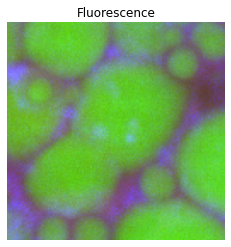

In [155]:
splitter = FuncSplitter(lambda o: df[df.fn == str(o).replace(path,'')].is_val.values[0])
splits = splitter(brightfield_paths)

tls = TfmdLists(range(len(brightfield_paths)), tfm, splits=splits)
show_at(tls.valid, 0)

In [158]:
dls = tls.dataloaders(bs=4)

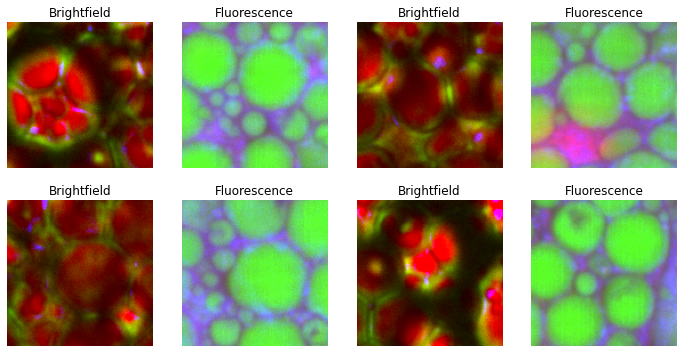

In [159]:
dls.show_batch()

In [160]:
xs, ys = dls.one_batch()

In [161]:
xs.shape

torch.Size([4, 7, 128, 128])

In [162]:
ys.shape

torch.Size([4, 3, 128, 128])

In [164]:
def resnet34_7chan(pretrained=True):
    resnet = models.resnet34(pretrained=pretrained)
    conv1 = nn.Conv2d(7, 64, kernel_size=7, stride=2, padding=3, bias=False)
    if pretrained:
        w = resnet.conv1.weight
        conv1.weight = nn.Parameter(torch.cat((w,
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:]),
               0.5*(w[:,:1,:,:]+w[:,2:,:,:])
              ),dim=1))
    resnet.conv1 = conv1
    return resnet

In [165]:
learn = unet_learner(dls, resnet34_7chan, n_out=3, loss_func=MSELossFlat(axis=1))

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=9.12010818865383e-07)

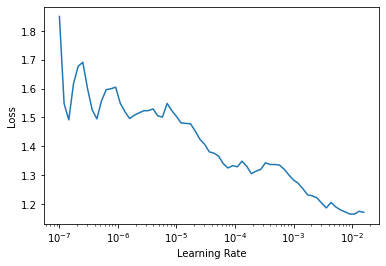

In [166]:
learn.lr_find()

In [167]:
learn.fine_tune(8, base_lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.975047,0.970294,00:06


epoch,train_loss,valid_loss,time
0,0.890184,0.682693,00:07
1,0.834337,0.552744,00:07
2,0.784797,0.554537,00:07
3,0.748435,0.550570,00:07
4,0.706988,0.499786,00:07
5,0.675463,0.448596,00:07
6,0.649009,0.462448,00:07
7,0.623380,0.455222,00:07


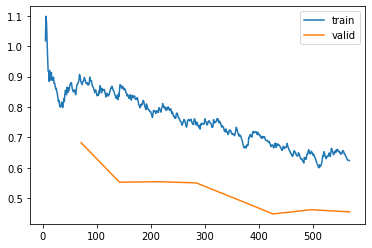

In [168]:
learn.recorder.plot_loss()

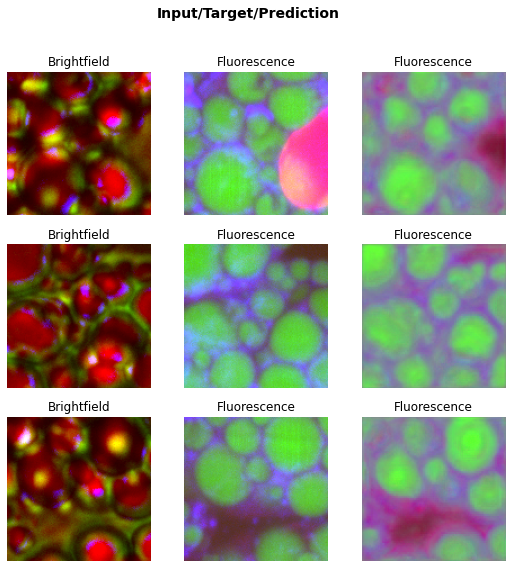

In [169]:
learn.show_results()

In [173]:
learn.fit_flat_cos(20, lr=1e-4)

epoch,train_loss,valid_loss,time
0,0.515211,0.418228,00:07
1,0.494902,0.454139,00:07
2,0.500381,0.424757,00:07
3,0.491793,0.518905,00:07
4,0.468829,0.386277,00:06
5,0.463804,0.388966,00:06
6,0.453070,0.411085,00:06
7,0.430418,0.408796,00:06
8,0.407858,0.363980,00:06
9,0.397821,0.384001,00:07


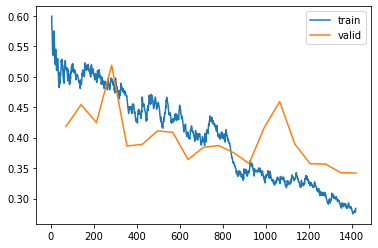

In [174]:
learn.recorder.plot_loss()

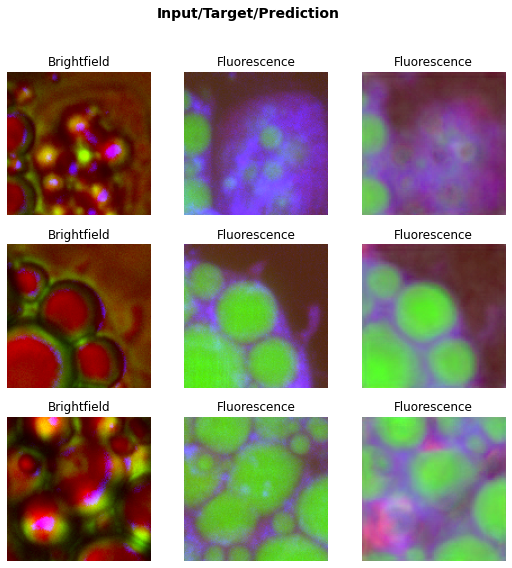

In [175]:
learn.show_results()

## Perceptual loss

In [176]:
import torch
import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks).cuda()
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)).cuda()
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)).cuda()
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss

In [177]:
learn = unet_learner(
    dls, 
    resnet34_7chan, 
    n_out=3, 
    loss_func=VGGPerceptualLoss()
)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0002290867705596611)

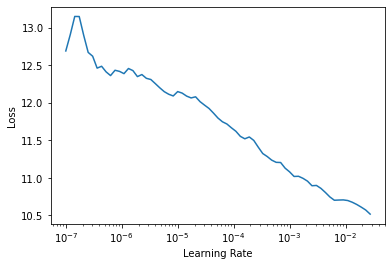

In [178]:
learn.lr_find()

In [179]:
learn.fine_tune(8, base_lr=1e-3)

epoch,train_loss,valid_loss,time
0,9.681099,9.588793,00:18


epoch,train_loss,valid_loss,time
0,9.034243,9.159569,00:19
1,8.668457,7.890142,00:19
2,8.351440,7.551885,00:19
3,8.066783,7.782056,00:19
4,7.909832,7.242330,00:19
5,7.669755,6.988328,00:19
6,7.568650,6.873007,00:19
7,7.415086,6.753358,00:19


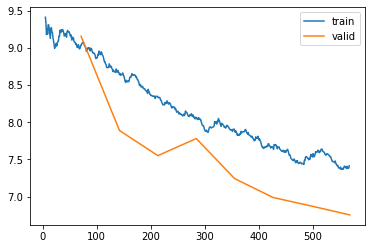

In [180]:
learn.recorder.plot_loss()

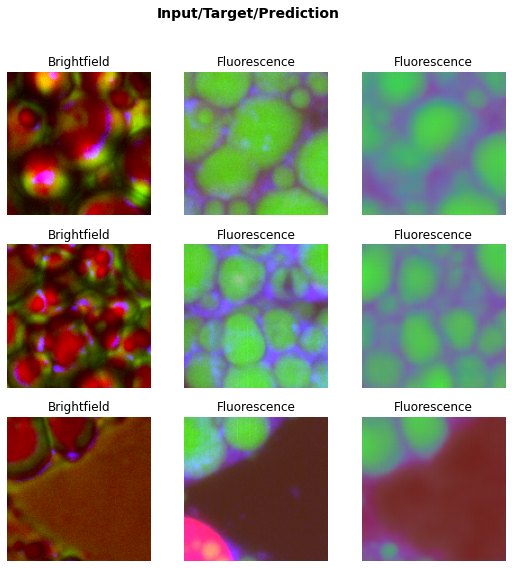

In [181]:
learn.show_results()

In [182]:
learn.fit_flat_cos(25, lr=1e-4)

epoch,train_loss,valid_loss,time
0,7.517987,6.955706,00:18
1,7.482617,6.677694,00:18
2,7.394797,6.851523,00:19
3,7.356895,6.704609,00:19
4,7.223666,6.650677,00:20
5,7.176390,6.503275,00:19
6,7.130527,6.532206,00:19
7,7.089508,6.536437,00:20
8,7.008353,6.619506,00:20
9,6.947123,6.446920,00:19


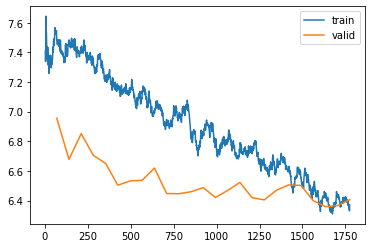

In [183]:
learn.recorder.plot_loss()

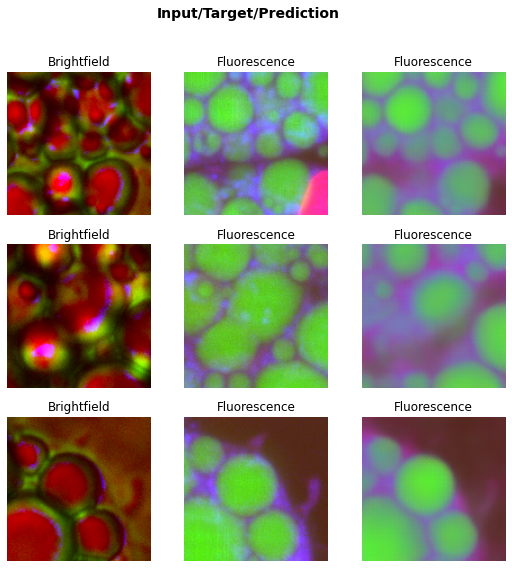

In [187]:
learn.show_results()